<a href="https://colab.research.google.com/github/nevinngyt/eyesense/blob/main/readme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

**Motivation**

This project seeks to improve Intraocular pressure (IOP)  measurement which is crucial for Glaucoma monitoring.  Current IOP measurements rely on Cornea applanation techniques which involves direct contact with the cornea. Direct contact with cornea for IOP measurement can be umcomfortable for people. Hence, this project seeks to achieve IOP measurement through indirect cornea contact, over the eyelids when the patient's eyes are closed.

**Currrent technique under exploration**

A mechanical actuator device (Still under development) with our in-house developed tactile sensor attached, will be used to contact with the patient's closed eyes, with a controlled force, speed and indentation displacement. An artificial eye with IOP as the control variable is set up, where sensor readings corresponding to different IOP levels are collected. These sensor readings together with the IOP labels are then passed through Machine Learning (ML) for us to predict unknown IOPs from sensor readings obtained through the aforementioned mechanical actuation method.  

**DISCLAIMER**

The datasets collected, mechanical actuator design and sensor for this project belong to Tee Research group, National University of Singapore and are not available for public sharing. This repository only seeks to share how tactile sensing data can be processed for Machine learning/AI classification tasks. This project is a continuation from the international James Dyson award winning project, Hopes, aka Home Eye Pressure E-skin Sensor (https://www.straitstimes.com/singapore/parenting-education/nus-students-win-top-international-james-dyson-award-with-glaucoma)

---



# Data Processing & ML/AI techniques

**Libaries used**

In [ ]:

# For file processing 
import os
import numpy as np
import csv
import os
import glob
import re
import sympy
import sys
import multiprocessing as mp


# For analytics/statistics purposes
from random import random
from random import randint
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import math
import statistics
from math import trunc
import math
from statistics import mean, stdev, median
from numpy import mean, absolute
from scipy.stats import kurtosis, skew
from functools import reduce
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
from itertools import compress

# For visualisation purposes
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits import mplot3d
from ipywidgets import interactive
import seaborn as sns
%matplotlib inline

# For ML/AI
import tensorflow as tf
from keras.models import Sequential
import keras.utils 
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, ConvLSTM2D, Dropout, Conv3D, MaxPooling3D, BatchNormalizationV1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold



## Pre-processing

**Accessing raw data through file directories**

In [ ]:
# Accessing raw data folders 
iop12_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop12_HOPESBOT_250822"
iop13_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop13_HOPESBOT_300822_"
iop14_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop14_HOPESBOT_250822_"
iop15_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop15_HOPESBOT_250822_"
iop16_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop16_HOPESBOT_300822_"
iop17_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop17_HOPESBOT_300822_"
iop18_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop18_HOPESBOT_310822"
iop19_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop19_HOPESBOT_010922"
iop20_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop20_HOPESBOT_310822"
iop21_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop21_HOPESBOT_310822"
iop22_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop22_HOPESBOT_310822"
iop23_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop23_HOPESBOT_010922_"
iop24_path = "/content/drive/MyDrive/Eyesense Project/Datasets_2022/05sept2022_Hopesbot/iop24_HOPESBOT_010922_"

# Converting file paths to directories for further processing 
iop12_directory = os.listdir(iop12_path)
iop13_directory = os.listdir(iop13_path)
iop14_directory = os.listdir(iop14_path)
iop15_directory = os.listdir(iop15_path)
iop16_directory = os.listdir(iop16_path)
iop17_directory = os.listdir(iop17_path)
iop18_directory = os.listdir(iop18_path)
iop19_directory = os.listdir(iop19_path)
iop20_directory = os.listdir(iop20_path)
iop21_directory = os.listdir(iop21_path)
iop22_directory = os.listdir(iop22_path)
iop23_directory = os.listdir(iop23_path)
iop24_directory = os.listdir(iop24_path)

A raw data file (Sensor readings corresponding to 1 mechanical actuation cycle) for one of the directories for e.g. IOP 12 directory, looks something like this:

---



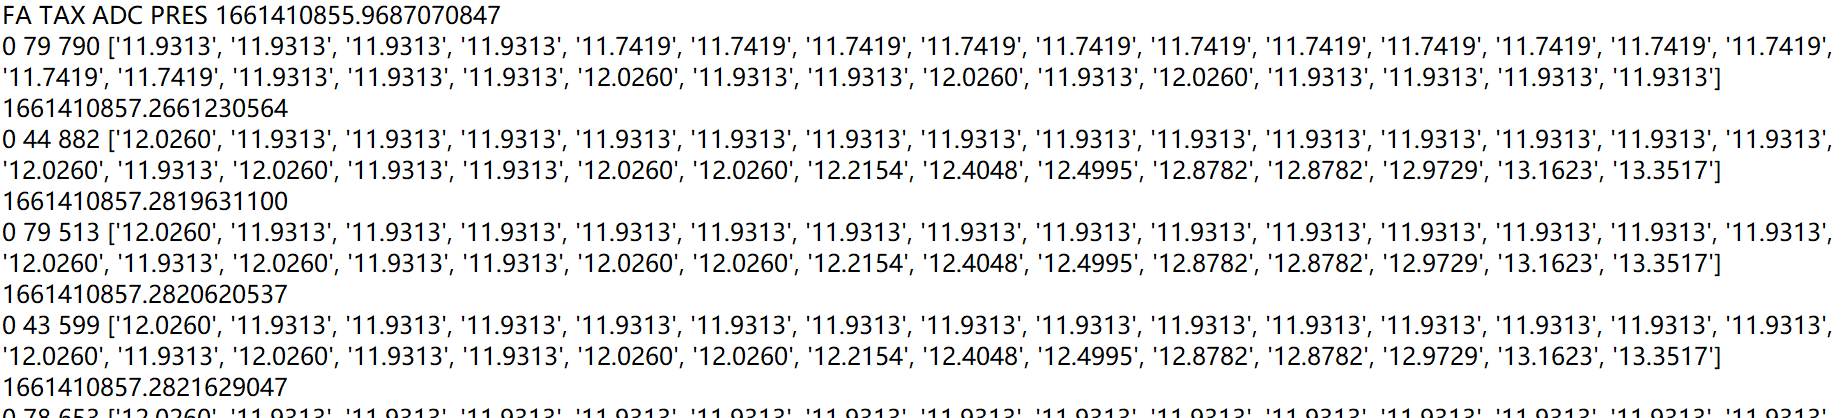

---

For this project, the sensor we use comprises of multiple 
sensor taxels that can each collect data. The data readings here are converted from Analog to Digital, whch corresponds to the values in the 3rd column. The data in the 2nd column represents the sensor taxel ID that is activated for the given time step. For the values bounded by the square brackets, they correspond to barometer sensor readings for us to monitor the IOP of the artificial eyeball. The values in the last column correspond to the absolute time recorded, which have to be subtracting the values with the minumum value instead for easy readability.

Here is a summary of the data format representation:

*   1st Column: Not important, Can be ignored
*   2nd Column: Sensor Taxel ID
*   3rd Column: Sensor Taxel reading (Digital reading)
*   4th Column: Barometer (IOP) readings
*   5th Column: Time



Hence, we have to convert into something readable and easier for processing for ML training. Something like this:

---



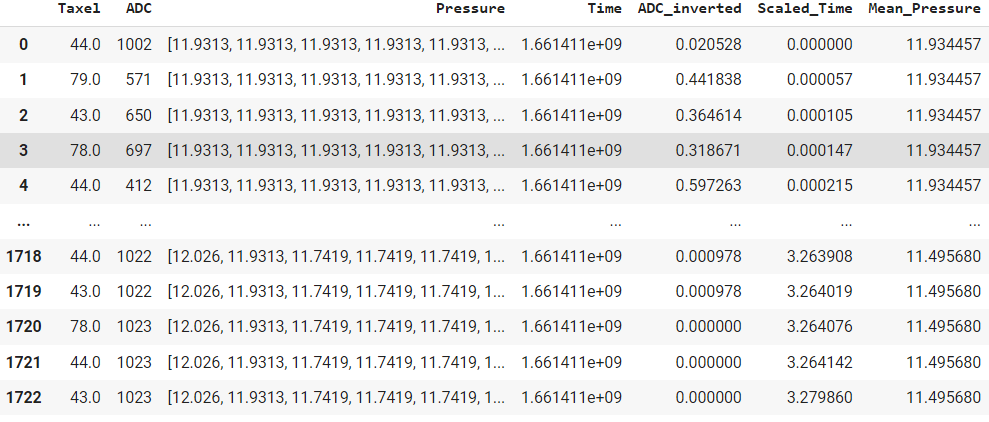

**Code for raw data conversion/processing**

The code blocks below are for the conversion/processing of the raw data into something that is more readable like the dataframe/table shown above

In [ ]:

# To remove nested String quotations and convert entry to float
# For function below later on 
def baro_proc(baro_array):
    baro_array = baro_array.split("'|,")
    baro_array = baro_array[0].split(",")
    baro_array = [i.replace("'", '') for i in baro_array]
    baro_array = [float(i) for i in baro_array]
    return baro_array



def proc_merged(path,dir):
    proc_merged_dir = []

    for i, file in enumerate(dir):

        # To split columns based on separators to convert data into a more organised table format
        # Method of splitting not limited to the one below
        sep = '[|]'
        df = pd.read_csv(path+"/"+file, sep=sep, header = 1, skipfooter = 1)
        left = df.iloc[:,0]
        left = left.str.split('[', expand=True)
        right = left.iloc[:,1]
        right = right.str.split(']', expand=True)
        left = left.iloc[:,0]
        left = left.str.split(' ', expand=True)
        left = left.drop(left.columns[3], axis=1)
        comb = pd.concat([left, right], axis=1)
        comb = comb.iloc[:, 1:]
        comb = comb.T.reset_index(drop=True).T
        comb = comb.rename(columns={0:"Taxel", 1:"ADC", 2:"Pressure", 3:"Time"})

        # Convert taxel ID to float value
        comb["Taxel"] = comb["Taxel"].apply(lambda x: float(x))

        # To process and clean up barometer values
        comb["Pressure"] = comb["Pressure"].apply(lambda x: baro_proc(x))

        # Standardise ADC 
        comb["ADC_inverted"] = comb["ADC"].apply(lambda x: (1023-int(x))/1023)
        

        # Standardise Time
        comb["Time"] = comb["Time"].apply(lambda x: float(x))
        comb["Scaled_Time"] = comb["Time"]-comb["Time"].min()

        

        # Take average pressure
        comb["Mean_Pressure"] = comb["Pressure"].apply(lambda x: sum(x)/len(x))

        proc_merged_dir.append(comb)

        # File processing counter
        print(i)

    return proc_merged_dir



Conversion of all the raw data

In [ ]:
iop12_proc_dir = proc_merged(iop12_path, iop12_directory)
iop13_proc_dir = proc_merged(iop13_path, iop13_directory)
iop14_proc_dir = proc_merged(iop14_path, iop14_directory)
iop15_proc_dir = proc_merged(iop15_path, iop15_directory)
iop16_proc_dir = proc_merged(iop16_path, iop16_directory)
iop17_proc_dir = proc_merged(iop17_path, iop17_directory)
iop18_proc_dir = proc_merged(iop18_path, iop18_directory)
iop19_proc_dir = proc_merged(iop19_path, iop19_directory)
iop20_proc_dir = proc_merged(iop20_path, iop20_directory)
iop21_proc_dir = proc_merged(iop21_path, iop21_directory)
iop22_proc_dir = proc_merged(iop22_path, iop22_directory)
iop23_proc_dir = proc_merged(iop23_path, iop23_directory)
iop24_proc_dir = proc_merged(iop24_path, iop24_directory)

Sample output ( 1 single data file). There are over 2000 data files processed

In [ ]:
iop12_proc_dir[1]

,Taxel,ADC,Pressure,Time,ADC_inverted,Scaled_Time,Mean_Pressure
0,44.0,1002,"[11.9313, 11.9313, 11.9313, 11.9313, 11.9313, ...",1.661411e+09,0.020528,0.000000,11.934457
1,79.0,571,"[11.9313, 11.9313, 11.9313, 11.9313, 11.9313, ...",1.661411e+09,0.441838,0.000057,11.934457
2,43.0,650,"[11.9313, 11.9313, 11.9313, 11.9313, 11.9313, ...",1.661411e+09,0.364614,0.000105,11.934457
3,78.0,697,"[11.9313, 11.9313, 11.9313, 11.9313, 11.9313, ...",1.661411e+09,0.318671,0.000147,11.934457
4,44.0,412,"[11.9313, 11.9313, 11.9313, 11.9313, 11.9313, ...",1.661411e+09,0.597263,0.000215,11.934457
...,...,...,...,...,...,...,...
1718,44.0,1022,"[12.026, 11.9313, 11.7419, 11.7419, 11.7419, 1...",1.661411e+09,0.000978,3.263908,11.495680
1719,43.0,1022,"[12.026, 11.9313, 11.7419, 11.7419, 11.7419, 1...",1.661411e+09,0.000978,3.264019,11.495680
1720,78.0,1023,"[12.026, 11.9313, 11.7419, 11.7419, 11.7419, 1...",1.661411e+09,0.000000,3.264076,11.495680
1721,44.0,1023,"[12.026, 11.9313, 11.7419, 11.7419, 11.7419, 1...",1.661411e+09,0.000000,3.264142,11.495680


Combine directories

In [ ]:
comb_dir = []
comb_dir.extend(iop12_proc_dir)
comb_dir.extend(iop13_proc_dir)
comb_dir.extend(iop14_proc_dir)
comb_dir.extend(iop15_proc_dir)
comb_dir.extend(iop16_proc_dir)
comb_dir.extend(iop17_proc_dir)
comb_dir.extend(iop18_proc_dir)
comb_dir.extend(iop19_proc_dir)
comb_dir.extend(iop20_proc_dir)
comb_dir.extend(iop21_proc_dir)
comb_dir.extend(iop22_proc_dir)
comb_dir.extend(iop23_proc_dir)
comb_dir.extend(iop24_proc_dir)


In [ ]:
# Size of combined dataset.

len(comb_dir)

2604

In [ ]:
# Sample of a single data file of combined dataset
comb_dir[0]

,Taxel,ADC,Pressure,Time,ADC_inverted,Scaled_Time,Mean_Pressure
0,44.0,882,"[12.026, 11.9313, 11.9313, 11.9313, 11.9313, 1...",1.661411e+09,0.137830,0.000000,12.177503
1,79.0,513,"[12.026, 11.9313, 11.9313, 11.9313, 11.9313, 1...",1.661411e+09,0.498534,0.000099,12.177503
2,43.0,599,"[12.026, 11.9313, 11.9313, 11.9313, 11.9313, 1...",1.661411e+09,0.414467,0.000200,12.177503
3,78.0,653,"[12.026, 11.9313, 11.9313, 11.9313, 11.9313, 1...",1.661411e+09,0.361681,0.000253,12.177503
4,44.0,382,"[12.026, 11.9313, 11.9313, 11.9313, 11.9313, 1...",1.661411e+09,0.626588,0.000299,12.177503
...,...,...,...,...,...,...,...
1732,44.0,1022,"[12.2154, 11.9313, 11.7419, 11.7419, 11.7419, ...",1.661411e+09,0.000978,3.248335,11.435703
1733,43.0,1022,"[12.2154, 11.9313, 11.7419, 11.7419, 11.7419, ...",1.661411e+09,0.000978,3.264038,11.435703
1734,78.0,1023,"[12.2154, 11.9313, 11.7419, 11.7419, 11.7419, ...",1.661411e+09,0.000000,3.264189,11.435703
1735,44.0,1023,"[12.2154, 11.9313, 11.7419, 11.7419, 11.7419, ...",1.661411e+09,0.000000,3.264365,11.435703


**Further data cleaning, reorganisation processing**

Code block

In [ ]:
def proc_merged_trunc(dir):

    new_dir = []

    for i, file in enumerate(dir):
        temp = file.drop(["ADC", "Time", "Pressure"], axis=1)
        temp = temp.rename(columns = {"ADC_inverted": "ADC", "Scaled_Time": "Time", "Mean_Pressure": "Pressure"})

        # Truncate time to simplify processing 
        temp["Time"] = temp["Time"].apply(lambda x : trunc(x*100)/100)


        time_lst = temp["Time"].tolist()
        time_lst = list(set(time_lst))

        # In case time not sorted in ascending order 
        time_lst.sort()

        pressure_lst_dict = {}
        adc_lst_dict = {}
        tax_lst_dict = {}


        for unique_time_step in time_lst:
            # Collate pressure, ADC, taxel ID corresponding to each time step to ensure data belongs to the correct time step
            pressure_lst_dict[unique_time_step] = mean(temp[temp["Time"]==unique_time_step]["Pressure"].tolist())
            adc_lst_dict[unique_time_step] = temp[temp["Time"]==unique_time_step]["ADC"].tolist()
            tax_lst_dict[unique_time_step] = temp[temp["Time"]==unique_time_step]["Taxel"].tolist()



        pressure_lst_sorted = sorted(pressure_lst_dict.items())
        pressure_lst_sorted = [x[1] for x in pressure_lst_sorted]


        adc_lst_sorted = sorted(adc_lst_dict.items())
        adc_lst_sorted = [x[1] for x in adc_lst_sorted]
        tax_lst_sorted = sorted(tax_lst_dict.items())
        tax_lst_sorted = [x[1] for x in tax_lst_sorted]

        # Create new dataframe with processed columns 
        comb_new_df = pd.DataFrame({"Time": time_lst, "ADC":adc_lst_sorted, "Taxel":tax_lst_sorted, "Pressure":pressure_lst_sorted})
        new_dir.append(comb_new_df)
        print(i)

    return new_dir

Processing of entire combined dataset

In [ ]:
comb_dir_proc = proc_merged_trunc(comb_dir)

Sample output of combined dataset

In [ ]:
comb_dir_proc[0]

,Time,ADC,Taxel,Pressure
0,0.00,"[0.1378299120234604, 0.49853372434017595, 0.41...","[44.0, 79.0, 43.0, 78.0, 44.0]",12.177503
1,0.01,"[0.7067448680351907, 0.7262952101661779, 0.677...","[79.0, 43.0, 78.0, 44.0, 79.0, 43.0, 78.0, 44.0]",12.177503
2,0.03,"[0.04594330400782014, 0.35288367546432065, 0.8...","[48.0, 49.0, 79.0, 80.0, 43.0, 78.0, 44.0, 45....",12.177503
3,0.04,"[0.8748778103616813, 0.6089931573802542, 0.781...","[44.0, 45.0, 48.0, 42.0, 77.0, 49.0, 79.0, 80....",16.520366
4,0.06,"[0.5356793743890518, 0.8660801564027371, 0.886...","[73.0, 49.0, 79.0, 80.0, 43.0, 78.0, 50.0, 74....",19.560370
...,...,...,...,...
201,3.20,"[0.8778103616813294, 0.11143695014662756, 0.19...","[44.0, 45.0, 48.0, 42.0, 77.0, 73.0, 49.0, 79....",19.958093
202,3.21,"[0.25317693059628543, 0.009775171065493646, 0....","[79.0, 80.0, 43.0, 78.0, 47.0, 50.0, 74.0, 44....",19.958093
203,3.23,"[0.0019550342130987292, 0.0009775171065493646,...","[48.0, 42.0, 77.0, 49.0, 79.0, 80.0, 43.0, 78....",19.958093
204,3.24,"[0.005865102639296188, 0.0, 0.0039100684261974...","[44.0, 79.0, 43.0, 78.0, 44.0]",11.435703


Add IOP Label


In [ ]:
def add_IOP(dir):

    for file in dir:
        file["IOP"] = round(file.loc[0, 'Pressure'])

    return dir

In [ ]:
comb_dir_proc = add_IOP(comb_dir_proc)
comb_dir_sorted = sorted(comb_dir_proc, key= lambda file: file.loc[0, "IOP"])


In [ ]:
comb_dir_sorted[0]

,Time,ADC,Taxel,Pressure,IOP
0,0.00,"[0.1378299120234604, 0.49853372434017595, 0.41...","[44.0, 79.0, 43.0, 78.0, 44.0]",12.177503,12
1,0.01,"[0.7067448680351907, 0.7262952101661779, 0.677...","[79.0, 43.0, 78.0, 44.0, 79.0, 43.0, 78.0, 44.0]",12.177503,12
2,0.03,"[0.04594330400782014, 0.35288367546432065, 0.8...","[48.0, 49.0, 79.0, 80.0, 43.0, 78.0, 44.0, 45....",12.177503,12
3,0.04,"[0.8748778103616813, 0.6089931573802542, 0.781...","[44.0, 45.0, 48.0, 42.0, 77.0, 49.0, 79.0, 80....",16.520366,12
4,0.06,"[0.5356793743890518, 0.8660801564027371, 0.886...","[73.0, 49.0, 79.0, 80.0, 43.0, 78.0, 50.0, 74....",19.560370,12
...,...,...,...,...,...
201,3.20,"[0.8778103616813294, 0.11143695014662756, 0.19...","[44.0, 45.0, 48.0, 42.0, 77.0, 73.0, 49.0, 79....",19.958093,12
202,3.21,"[0.25317693059628543, 0.009775171065493646, 0....","[79.0, 80.0, 43.0, 78.0, 47.0, 50.0, 74.0, 44....",19.958093,12
203,3.23,"[0.0019550342130987292, 0.0009775171065493646,...","[48.0, 42.0, 77.0, 49.0, 79.0, 80.0, 43.0, 78....",19.958093,12
204,3.24,"[0.005865102639296188, 0.0, 0.0039100684261974...","[44.0, 79.0, 43.0, 78.0, 44.0]",11.435703,12


Here are the meanings of each column for thew newly processed format (For 1 data file):

* Time: Standardised, where the raw values are subtracted with the first raw time step value

* ADC: The digital sensor reading corresponding to each activated sensor taxel (In the same order as the Taxel column). 
Note that the ADC column values are the raw sensor values subtracted from the maximum digital value possible (1023), to make it easier to interpret the sensor readings.
Note that the possible range of digital readings is from 0 - 1023. Previously, for the raw data, 0 represents the maximum activation of a taxel, where 1023 represents complete inactivation. Hence, to make it more intutitive for understanding, we subtract the sensor readings from 1023 to "reverse" the meanings i.e. to make 0 represent complete inactivation, 1023 represnting complete activation

* Taxel: The respective taxel IDs that are activated for each given time step

* Mean Pressure: The average barometer reading from the array of barometer raw values.

* IOP: The IOP label that is tagged with the data file for ML training later. Over here, the IOP label is taken from the mean pressure reading from the first time step, before the actuator acts on the artificial eye

**Including spatial location into dataset.**

Our team is interested in exploring the use of the spatial-temporal information as the sensors get activated upon actuation by our device. We hope to explore the relationship between the spatial-temporal sensor response and different IOP levels. Hence, it is improtant for us to include the spatial coordinates into our dataset

For this project, we used a total of 40 sensor taxels, where the ID ranges from 40 - 79. Here is the sensor taxel physical layout/where each taxel ID is located at:

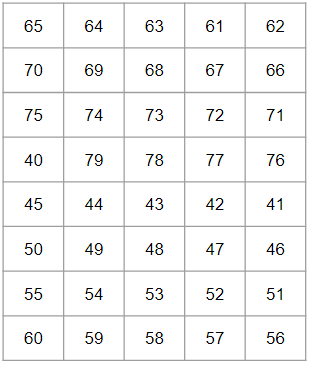

Over here, we first create a 2D array that resembles this sensor taxel physical layout

In [ ]:
# Initialise Sensor matrix
rows, cols = 8, 5
Matrix = [[0 for y in range(cols)] for x in range(rows)]

top_first = 61.0
bot_first = 41.0

for x in range(rows//2):
    for y in range(cols-1, -1, -1):
        Matrix[x][y] = top_first
        top_first+=1

Matrix[0][-1], Matrix[0][-2] = Matrix[0][-2], Matrix[0][-1]
Matrix[3][0] = 40.0

for x in range(rows//2, rows):
    for y in range(cols-1, -1, -1):
        Matrix[x][y] = bot_first
        bot_first+=1

How the sensor 2D array layout looks like

In [ ]:
Matrix

[[65.0, 64.0, 63.0, 61.0, 62.0],
 [70.0, 69.0, 68.0, 67.0, 66.0],
 [75.0, 74.0, 73.0, 72.0, 71.0],
 [40.0, 79.0, 78.0, 77.0, 76.0],
 [45.0, 44.0, 43.0, 42.0, 41.0],
 [50.0, 49.0, 48.0, 47.0, 46.0],
 [55.0, 54.0, 53.0, 52.0, 51.0],
 [60.0, 59.0, 58.0, 57.0, 56.0]]

We need to find out the 2D coordinates of each taxel ID based on this sensor physical layout. The code blocks for doing so are as shown below

In [ ]:
# Finding row and columns coordinates for each taxel ID
def index_2d(tax):

    # Initialise Sensor matrix
    rows, cols = 8, 5
    Matrix = [[0 for y in range(cols)] for x in range(rows)]

    top_first = 61.0
    bot_first = 41.0

    for x in range(rows//2):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = top_first
            top_first+=1

    Matrix[0][-1], Matrix[0][-2] = Matrix[0][-2], Matrix[0][-1]
    Matrix[3][0] = 40.0

    for x in range(rows//2, rows):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = bot_first
            bot_first+=1

    for i, x in enumerate(Matrix):
        if tax in x:
            return (i, x.index(tax))

# Finding only row coordinates for each taxel ID

def index_2d_row(tax):

    # Initialise Sensor matrix
    rows, cols = 8, 5
    Matrix = [[0 for y in range(cols)] for x in range(rows)]

    top_first = 61.0
    bot_first = 41.0

    for x in range(rows//2):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = top_first
            top_first+=1

    Matrix[0][-1], Matrix[0][-2] = Matrix[0][-2], Matrix[0][-1]
    Matrix[3][0] = 40.0

    for x in range(rows//2, rows):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = bot_first
            bot_first+=1

    for i, x in enumerate(Matrix):
        if tax in x:
            return i

# Finding only column coordinates for each taxel ID

def index_2d_col(tax):

    # Initialise Sensor matrix
    rows, cols = 8, 5
    Matrix = [[0 for y in range(cols)] for x in range(rows)]

    top_first = 61.0
    bot_first = 41.0

    for x in range(rows//2):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = top_first
            top_first+=1

    Matrix[0][-1], Matrix[0][-2] = Matrix[0][-2], Matrix[0][-1]
    Matrix[3][0] = 40.0

    for x in range(rows//2, rows):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = bot_first
            bot_first+=1

    for i, x in enumerate(Matrix):
        if tax in x:
            return x.index(tax)

In [ ]:
# Code correction as raw taxel ID starts from 41 to 80, but sensor layout matrix starts from 40 to 79
def taxel_shift(tax):
    return tax-1.0

In [ ]:
comb_dir_sorted[0]

,Time,ADC,Taxel,Pressure,IOP
0,0.00,"[0.1378299120234604, 0.49853372434017595, 0.41...","[44.0, 79.0, 43.0, 78.0, 44.0]",12.177503,12
1,0.01,"[0.7067448680351907, 0.7262952101661779, 0.677...","[79.0, 43.0, 78.0, 44.0, 79.0, 43.0, 78.0, 44.0]",12.177503,12
2,0.03,"[0.04594330400782014, 0.35288367546432065, 0.8...","[48.0, 49.0, 79.0, 80.0, 43.0, 78.0, 44.0, 45....",12.177503,12
3,0.04,"[0.8748778103616813, 0.6089931573802542, 0.781...","[44.0, 45.0, 48.0, 42.0, 77.0, 49.0, 79.0, 80....",16.520366,12
4,0.06,"[0.5356793743890518, 0.8660801564027371, 0.886...","[73.0, 49.0, 79.0, 80.0, 43.0, 78.0, 50.0, 74....",19.560370,12
...,...,...,...,...,...
201,3.20,"[0.8778103616813294, 0.11143695014662756, 0.19...","[44.0, 45.0, 48.0, 42.0, 77.0, 73.0, 49.0, 79....",19.958093,12
202,3.21,"[0.25317693059628543, 0.009775171065493646, 0....","[79.0, 80.0, 43.0, 78.0, 47.0, 50.0, 74.0, 44....",19.958093,12
203,3.23,"[0.0019550342130987292, 0.0009775171065493646,...","[48.0, 42.0, 77.0, 49.0, 79.0, 80.0, 43.0, 78....",19.958093,12
204,3.24,"[0.005865102639296188, 0.0, 0.0039100684261974...","[44.0, 79.0, 43.0, 78.0, 44.0]",11.435703,12


Adding taxel locations into dataset

In [ ]:
def tax_pos_proc(dir):

    # Get position of tax
    
    for file in dir:
        file["Taxel"] = file["Taxel"].apply(lambda x: list(map(taxel_shift, x)))
        file["row_pos"] = file["Taxel"].apply(lambda x: list(map(index_2d_row, x)))
        file["col_pos"] = file["Taxel"].apply(lambda x: list(map(index_2d_col, x)))
        file["tax_pos"] = file["Taxel"].apply(lambda x: list(map(index_2d, x)))
        

    return dir 

In [ ]:
comb_dir_sorted_tax_pos = tax_pos_proc(comb_dir_sorted)

How dataset now looks like with added sensor location coordinates added

In [ ]:
comb_dir_sorted_tax_pos[0]

,Time,ADC,Taxel,Pressure,IOP,row_pos,col_pos,tax_pos
0,0.00,"[0.1378299120234604, 0.49853372434017595, 0.41...","[43.0, 78.0, 42.0, 77.0, 43.0]",12.177503,12,"[4, 3, 4, 3, 4]","[2, 2, 3, 3, 2]","[(4, 2), (3, 2), (4, 3), (3, 3), (4, 2)]"
1,0.01,"[0.7067448680351907, 0.7262952101661779, 0.677...","[78.0, 42.0, 77.0, 43.0, 78.0, 42.0, 77.0, 43.0]",12.177503,12,"[3, 4, 3, 4, 3, 4, 3, 4]","[2, 3, 3, 2, 2, 3, 3, 2]","[(3, 2), (4, 3), (3, 3), (4, 2), (3, 2), (4, 3..."
2,0.03,"[0.04594330400782014, 0.35288367546432065, 0.8...","[47.0, 48.0, 78.0, 79.0, 42.0, 77.0, 43.0, 44....",12.177503,12,"[5, 5, 3, 3, 4, 3, 4, 4, 5, 4, 3, 5, 3, 3, 4, 3]","[3, 2, 2, 1, 3, 3, 2, 1, 3, 4, 4, 2, 2, 1, 3, 3]","[(5, 3), (5, 2), (3, 2), (3, 1), (4, 3), (3, 3..."
3,0.04,"[0.8748778103616813, 0.6089931573802542, 0.781...","[43.0, 44.0, 47.0, 41.0, 76.0, 48.0, 78.0, 79....",16.520366,12,"[4, 4, 5, 4, 3, 5, 3, 3, 4, 3, 5, 2, 4, 4, 5, ...","[2, 1, 3, 4, 4, 2, 2, 1, 3, 3, 1, 2, 2, 1, 3, ...","[(4, 2), (4, 1), (5, 3), (4, 4), (3, 4), (5, 2..."
4,0.06,"[0.5356793743890518, 0.8660801564027371, 0.886...","[72.0, 48.0, 78.0, 79.0, 42.0, 77.0, 49.0, 73....",19.560370,12,"[2, 5, 3, 3, 4, 3, 5, 2, 4, 4, 5, 4, 3, 2, 5, ...","[3, 2, 2, 1, 3, 3, 1, 2, 2, 1, 3, 4, 4, 3, 2, ...","[(2, 3), (5, 2), (3, 2), (3, 1), (4, 3), (3, 3..."
...,...,...,...,...,...,...,...,...
201,3.20,"[0.8778103616813294, 0.11143695014662756, 0.19...","[43.0, 44.0, 47.0, 41.0, 76.0, 72.0, 48.0, 78....",19.958093,12,"[4, 4, 5, 4, 3, 2, 5, 3, 3, 4, 3, 5, 5, 2, 4, ...","[2, 1, 3, 4, 4, 3, 2, 2, 1, 3, 3, 4, 1, 2, 2, ...","[(4, 2), (4, 1), (5, 3), (4, 4), (3, 4), (2, 3..."
202,3.21,"[0.25317693059628543, 0.009775171065493646, 0....","[78.0, 79.0, 42.0, 77.0, 46.0, 49.0, 73.0, 43....",19.958093,12,"[3, 3, 4, 3, 5, 5, 2, 4, 4, 5, 4, 3, 2, 5, 3, ...","[2, 1, 3, 3, 4, 1, 2, 2, 1, 3, 4, 4, 3, 2, 2, ...","[(3, 2), (3, 1), (4, 3), (3, 3), (5, 4), (5, 1..."
203,3.23,"[0.0019550342130987292, 0.0009775171065493646,...","[47.0, 41.0, 76.0, 48.0, 78.0, 79.0, 42.0, 77....",19.958093,12,"[5, 4, 3, 5, 3, 3, 4, 3, 4, 4, 5, 4, 5, 3, 4, 3]","[3, 4, 4, 2, 2, 1, 3, 3, 2, 1, 3, 4, 2, 2, 3, 3]","[(5, 3), (4, 4), (3, 4), (5, 2), (3, 2), (3, 1..."
204,3.24,"[0.005865102639296188, 0.0, 0.0039100684261974...","[43.0, 78.0, 42.0, 77.0, 43.0]",11.435703,12,"[4, 3, 4, 3, 4]","[2, 2, 3, 3, 2]","[(4, 2), (3, 2), (4, 3), (3, 3), (4, 2)]"


## Features Processing

**Initial preparation**

To prepare spatial-temporal related features for ML, we need to create a new dataframe with IOP labels and new data columns based on the original columns, especially the taxel location shown above. Before this, we need to add in new data columns using taxel locations, ADC, time to make it easier for features processing later on. There are a few approaches we tried on using the taxel locations. The most recent one was where we find the centroid taxel i.e. the centrally located taxel that is activated among all the activated taxels

The code blocks for getting the centroid taxel and using it to get additional data columns are as shown below

In [ ]:
# Get set of taxels activated for 1 data file

def get_act_taxs(file):
    act_taxs = []

    taxs = file["Taxel"].tolist()

    for tax_lst in taxs:
        for tax in tax_lst:
            act_taxs.append(tax)

    return list(set(act_taxs))


In [ ]:
# Plot activated taxels from sensor matrix - optional to use
# Helps to visualise where are the activated taxels based on the sensor matrix

def plot_act_taxs(file):
    a = np.zeros([8, 5], dtype = int)

    activated_taxs = get_act_taxs(file)
    activated_taxs_pos = list(map(index_2d, activated_taxs))

    for pos in activated_taxs_pos:
        a[pos[0]][pos[1]] = 1

    ax = sns.heatmap(a, linewidth=0.5, cmap='Reds', cbar= False)
    plt.show()

In [ ]:
# Get taxel ID from location coordinates

def get_tax_from_idx(pos):
    # pos is tuple
    row_pos = pos[0]
    col_pos = pos[1]

    # Initialise Sensor matrix
    rows, cols = 8, 5
    Matrix = [[0 for y in range(cols)] for x in range(rows)]

    top_first = 61.0
    bot_first = 41.0

    for x in range(rows//2):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = top_first
            top_first+=1

    Matrix[0][-1], Matrix[0][-2] = Matrix[0][-2], Matrix[0][-1]
    Matrix[3][0] = 40.0

    for x in range(rows//2, rows):
        for y in range(cols-1, -1, -1):
            Matrix[x][y] = bot_first
            bot_first+=1

    return Matrix[row_pos][col_pos]

In [ ]:

# Finding the centroid taxel coordinates plus taxel ID

def get_centroid(file):
    all_pos = file["tax_pos"].tolist()
    # all_pos = tuple(map(tuple, all_pos))

    coord = np.mean(list(map(lambda x: np.mean(x, axis=0), all_pos)), axis=0)
    return (round(coord[0]), round(coord[1])), get_tax_from_idx((round(coord[0]), round(coord[1])))


In [ ]:
# Getting the IOP labels for train/test set preparation later on for ML
def get_iop(dir):
    iop_store = []

    for file in dir:
        iop_store.append(file.loc[0, "IOP"])

    return iop_store


In [ ]:
comb_iop_store = get_iop(comb_dir_sorted_tax_pos)

In [ ]:
# Removing data with exceeded IOP labels (Correct IOP label range should be from 12 to 24 mm Hg)
comb_iop_store = comb_iop_store[:-8]
comb_dir_sorted_tax_pos = comb_dir_sorted_tax_pos[:-8]

In [ ]:
comb_dir_sorted_tax_pos[-1]

,Time,ADC,Taxel,Pressure,IOP,row_pos,col_pos,tax_pos
0,0.00,"[0.6119257086999023, 0.27468230694037143]","[77.0, 78.0]",24.127760,24,"[3, 3]","[3, 2]","[(3, 3), (3, 2)]"
1,0.01,"[0.044965786901270774, 0.4222873900293255, 0.8...","[42.0, 76.0, 77.0, 78.0, 72.0, 43.0, 42.0, 76.0]",24.127760,24,"[4, 3, 3, 3, 2, 4, 4, 3]","[3, 4, 3, 2, 3, 2, 3, 4]","[(4, 3), (3, 4), (3, 3), (3, 2), (2, 3), (4, 2..."
2,0.03,"[0.895405669599218, 0.83088954056696, 0.639296...","[77.0, 78.0, 72.0, 73.0, 43.0, 42.0, 76.0, 41....",24.127760,24,"[3, 3, 2, 2, 4, 4, 3, 4, 3, 3, 2, 2, 4, 4]","[3, 2, 3, 2, 2, 3, 4, 4, 3, 2, 3, 2, 2, 3]","[(3, 3), (3, 2), (2, 3), (2, 2), (4, 2), (4, 3..."
3,0.04,"[0.4789833822091887, 0.8934506353861192, 0.815...","[71.0, 76.0, 41.0, 77.0, 78.0, 79.0, 72.0, 47....",27.943850,24,"[2, 3, 4, 3, 3, 3, 2, 5, 2, 4, 4, 2, 3, 4, 3, ...","[4, 4, 4, 3, 2, 1, 3, 3, 2, 2, 3, 4, 4, 4, 3, ...","[(2, 4), (3, 4), (4, 4), (3, 3), (3, 2), (3, 1..."
4,0.06,"[0.8924731182795699, 0.7556207233626588, 0.870...","[72.0, 47.0, 73.0, 43.0, 42.0, 71.0, 76.0, 41....",27.943850,24,"[2, 5, 2, 4, 4, 2, 3, 4, 3, 3, 3, 2, 5, 2, 4, ...","[3, 3, 2, 2, 3, 4, 4, 4, 3, 2, 1, 3, 3, 2, 2, ...","[(2, 3), (5, 3), (2, 2), (4, 2), (4, 3), (2, 4..."
...,...,...,...,...,...,...,...,...
234,3.20,"[0.03812316715542522, 0.3939393939393939, 0.03...","[79.0, 72.0, 47.0, 73.0, 43.0, 42.0, 71.0, 76....",33.275047,24,"[3, 2, 5, 2, 4, 4, 2, 3, 4, 3, 3, 3, 2]","[1, 3, 3, 2, 2, 3, 4, 4, 4, 3, 2, 1, 3]","[(3, 1), (2, 3), (5, 3), (2, 2), (4, 2), (4, 3..."
235,3.21,"[0.005865102639296188, 0.022482893450635387, 0...","[47.0, 73.0, 43.0, 42.0, 71.0, 76.0, 41.0, 77....",33.275047,24,"[5, 2, 4, 4, 2, 3, 4, 3, 3, 3, 2, 5, 2, 4, 4, ...","[3, 2, 2, 3, 4, 4, 4, 3, 2, 1, 3, 3, 2, 2, 3, ...","[(5, 3), (2, 2), (4, 2), (4, 3), (2, 4), (3, 4..."
236,3.23,"[0.17302052785923755, 0.033235581622678395, 0....","[77.0, 78.0, 79.0, 72.0, 47.0, 73.0, 43.0, 42....",33.275047,24,"[3, 3, 3, 2, 5, 2, 4, 4, 2, 3, 4, 3, 3, 2, 2, ...","[3, 2, 1, 3, 3, 2, 2, 3, 4, 4, 4, 3, 2, 3, 2, ...","[(3, 3), (3, 2), (3, 1), (2, 3), (5, 3), (2, 2..."
237,3.24,"[0.006842619745845552, 0.0, 0.0068426197458455...","[76.0, 41.0, 77.0, 78.0, 72.0, 43.0, 42.0, 76....",23.320538,24,"[3, 4, 3, 3, 2, 4, 4, 3, 3, 3]","[4, 4, 3, 2, 3, 2, 3, 4, 3, 2]","[(3, 4), (4, 4), (3, 3), (3, 2), (2, 3), (4, 2..."


Using centroid taxel to do the following:
* Convert Taxel locations with respect to centroid taxel location, where centroid taxel location is now regarded as the new origin

* To find the distance of each activated taxel from the centroid taxel

* To get the ADC difference between each activated taxel & centroid taxel

In [ ]:
# To convert taxel location coordinates with respect to centroid taxel location
def convert_cen_coords(tax_positions, cen_coords):
    converted_taxs = []

    for tax_pos in tax_positions:
        new_tax_pos = (tax_pos[0] - cen_coords[0], tax_pos[1] - cen_coords[1])
        converted_taxs.append(new_tax_pos)

    return converted_taxs

# To calculate the distance of each activated taxel from the centroid taxel
def get_distance(cen_coords, centroid_pos):

    cen_dis = []

    for pos in cen_coords:
        dist = math.hypot(pos[0]-centroid_pos[0], pos[1]-centroid_pos[1])
        
        cen_dis.append(dist)

    return cen_dis

# To calculate the digital reading difference between each activated taxel and the centroid taxel
def get_adc_diff(adc_lst, tax_positions, centroid_pos):

    if centroid_pos not in tax_positions:
        centroid_adc = mean(adc_lst)
    else:
        centroid_index = tax_positions.index(centroid_pos)

        centroid_adc = adc_lst[centroid_index]

    adc_diff_wrt_cen = []

    for adc in adc_lst:
        adcdiff = adc-centroid_adc
        adc_diff_wrt_cen.append(adcdiff)

    return adc_diff_wrt_cen

# After finding the distance and digital reading difference, 
# to calculate difference over distance as a form of representation of the spatial pressure gradient across taxels 
def adc_over_dist(adc_diff, cen_dist):
    adc_over_dist = []

    for ad_diff, dis in zip(adc_diff, cen_dist):
        adc_over_dist.append(ad_diff/dis)

    return adc_over_dist


In [ ]:
# To add in the new columns into dataset
# New columns are the taxel location coordinates w.r.t centroid taxel location, distance of each taxel from centroid taxel,
# Digital reading difference, Digital reading difference over distance with statistical features based on it e.g. max, mean, standard deviation

import math

def sec_proc(dir):
    new_dir = []

    for i, file in enumerate(dir):
        centroid_coords = get_centroid(file)[0]
        file["cen_coords"] = file["tax_pos"].apply(lambda x: convert_cen_coords(x, centroid_coords))
        file["cen_distance"] = file["cen_coords"].apply(lambda x: get_distance(x, centroid_coords))
        file["adc_diff"] = file.apply(lambda x: get_adc_diff(x.ADC, x.tax_pos, centroid_coords), axis=1)
        file["adc_diff_over_dist"] = file.apply(lambda x: adc_over_dist(x.adc_diff, x.cen_distance), axis=1)
        file["max_adc_diff_over_dist"] = file["adc_diff_over_dist"].apply(lambda x: max(x))
        file["mean_adc_diff_over_dist"] = file["adc_diff_over_dist"].apply(lambda x: mean(x))
        file["min_adc_diff_over_dist"] = file["adc_diff_over_dist"].apply(lambda x: min(x))
        file["std_adc_diff_over_dist"] = file["adc_diff_over_dist"].apply(lambda x: stdev(x) if len(x)>1 else 0)
        new_dir.append(file)
        print(i)

    return new_dir

In [ ]:
comb_dir_sorted_tax_pos_cen = sec_proc(comb_dir_sorted_tax_pos)

In [ ]:
# Sample of processed output of new data columns added
comb_dir_sorted_tax_pos_cen[0]

,Time,ADC,Taxel,Pressure,IOP,row_pos,col_pos,tax_pos,ADC_sum,num_taxs,adc_per_tax,cen_coords,cen_distance,adc_diff,adc_diff_over_dist,max_adc_diff_over_dist,mean_adc_diff_over_dist,min_adc_diff_over_dist,std_adc_diff_over_dist
0,0.00,"[0.1378299120234604, 0.49853372434017595, 0.41...","[43.0, 78.0, 42.0, 77.0, 43.0]",12.177503,12,"[4, 3, 4, 3, 4]","[2, 2, 3, 3, 2]","[(4, 2), (3, 2), (4, 3), (3, 3), (4, 2)]",2.039101,5,0.407820,"[(0, 0), (-1, 0), (0, 1), (-1, 1), (0, 0)]","[4.47213595499958, 5.385164807134504, 4.123105...","[0.0, 0.36070381231671556, 0.2766373411534702,...","[0.0, 0.06698101640990434, 0.06709441044504617...",0.109290,0.057453,0.000000,0.039860
1,0.01,"[0.7067448680351907, 0.7262952101661779, 0.677...","[78.0, 42.0, 77.0, 43.0, 78.0, 42.0, 77.0, 43.0]",12.177503,12,"[3, 4, 3, 4, 3, 4, 3, 4]","[2, 3, 3, 2, 2, 3, 3, 2]","[(3, 2), (4, 3), (3, 3), (4, 2), (3, 2), (4, 3...",6.197458,8,0.774682,"[(-1, 0), (0, 1), (-1, 1), (0, 0), (-1, 0), (0...","[5.385164807134504, 4.123105625617661, 5.09901...","[-0.07331378299120228, -0.053763440860215006, ...","[-0.0136140277255903, -0.013039549733136169, -...",0.018579,-0.000758,-0.020129,0.013578
2,0.03,"[0.04594330400782014, 0.35288367546432065, 0.8...","[47.0, 48.0, 78.0, 79.0, 42.0, 77.0, 43.0, 44....",12.177503,12,"[5, 5, 3, 3, 4, 3, 4, 4, 5, 4, 3, 5, 3, 3, 4, 3]","[3, 2, 2, 1, 3, 3, 2, 1, 3, 4, 4, 2, 2, 1, 3, 3]","[(5, 3), (5, 2), (3, 2), (3, 1), (4, 3), (3, 3...",9.985337,16,0.624084,"[(1, 1), (1, 0), (-1, 0), (-1, -1), (0, 1), (-...","[3.1622776601683795, 3.605551275463989, 5.3851...","[-0.8250244379276638, -0.5180840664711632, -0....","[-0.2608956349151625, -0.14369066666635946, -0...",0.001815,-0.060644,-0.260896,0.073182
3,0.04,"[0.8748778103616813, 0.6089931573802542, 0.781...","[43.0, 44.0, 47.0, 41.0, 76.0, 48.0, 78.0, 79....",16.520366,12,"[4, 4, 5, 4, 3, 5, 3, 3, 4, 3, 5, 2, 4, 4, 5, ...","[2, 1, 3, 4, 4, 2, 2, 1, 3, 3, 1, 2, 2, 1, 3, ...","[(4, 2), (4, 1), (5, 3), (4, 4), (3, 4), (5, 2...",12.548387,17,0.738140,"[(0, 0), (0, -1), (1, 1), (0, 2), (-1, 2), (1,...","[4.47213595499958, 5.0, 3.1622776601683795, 4....","[0.0, -0.26588465298142716, -0.093841642228739...","[0.0, -0.053176930596285435, -0.02967533288134...",0.002360,-0.029696,-0.193999,0.046749
4,0.06,"[0.5356793743890518, 0.8660801564027371, 0.886...","[72.0, 48.0, 78.0, 79.0, 42.0, 77.0, 49.0, 73....",19.560370,12,"[2, 5, 3, 3, 4, 3, 5, 2, 4, 4, 5, 4, 3, 2, 5, ...","[3, 2, 2, 1, 3, 3, 1, 2, 2, 1, 3, 4, 4, 3, 2, ...","[(2, 3), (5, 2), (3, 2), (3, 1), (4, 3), (3, 3...",15.576735,20,0.778837,"[(-2, 1), (1, 0), (-1, 0), (-1, -1), (0, 1), (...","[6.082762530298219, 3.605551275463989, 5.38516...","[-0.34408602150537637, -0.013685239491691092, ...","[-0.05656739348141327, -0.003795602515715152, ...",0.001271,-0.020806,-0.132712,0.033833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,3.20,"[0.8778103616813294, 0.11143695014662756, 0.19...","[43.0, 44.0, 47.0, 41.0, 76.0, 72.0, 48.0, 78....",19.958093,12,"[4, 4, 5, 4, 3, 2, 5, 3, 3, 4, 3, 5, 5, 2, 4, ...","[2, 1, 3, 4, 4, 3, 2, 2, 1, 3, 3, 4, 1, 2, 2, ...","[(4, 2), (4, 1), (5, 3), (4, 4), (3, 4), (2, 3...",4.718475,21,0.224689,"[(0, 0), (0, -1), (1, 1), (0, 2), (-1, 2), (-2...","[4.47213595499958, 5.0, 3.1622776601683795, 4....","[0.0, -0.7663734115347018, -0.6832844574780059...","[0.0, -0.15327468230694036, -0.216073517542296...",0.000000,-0.150396,-0.292278,0.086421
202,3.21,"[0.25317693059628543, 0.009775171065493646, 0....","[78.0, 79.0, 42.0, 77.0, 46.0, 49.0, 73.0, 43....",19.958093,12,"[3, 3, 4, 3, 5, 5, 2, 4, 4, 5, 4, 3, 2, 5, 3, ...","[2, 1, 3, 3, 4, 1, 2, 2, 1, 3, 4, 4, 3, 2, 2, ...","[(3, 2), (3, 1), (4, 3), (3, 3), (5, 4), (5, 1...",2.838710,22,0.129032,"[(-1, 0), (-1, -1), (0, 1), (-1, 1), (1, 2), (...","[5.385164807134504, 5.830951894845301, 4.12310...","[-0.44183773216031286, -0.6852394916911047, 0....","[-0.08204720709289097, -0.11751760330879639, 0...",0.019441,-0.121764,-0.231672,0.060568
203,3.23,"[0.00195

Note: For the "ADC_sum", "num_taxs", "adc_per_tax" columns over here, the code to achieve them are not shown as they are new data columns based on another approach to get the spatial-temporal features. Essentially they are based on the ADC and taxel columns to find the sum of the values from these columns respectively, and that using these 2 new column values to obtain the values in the "adc_per_tax" column


**Final features preparation for train/test set for ML**

For the features used for the final train/test set for ML, they are mainly statistical features of the data frame columns except the IOP and Pressure columns. For the gradient-based features, they are mainly obtained using the first derivative values of the columns involved, where the diff_consecutive_nums function is used. Statistical features include the following:

* Max
*   Mean
*   Min
* Standard Deviation
* Kurtosis
* Skewness 
* Median
* Inter-quartile range








In [ ]:
# New - Additional features
## extracting features for data visualisations

import copy

def diff_consecutive_nums(nums):
    result = [b-a for a, b in zip(nums[:-1], nums[1:])]
    return result


def alt_features_extraction(dir, iop_store):
    
    
    # Max 

    max_ADC_sum = []
    max_ADC_per_tax = []
    max_num_taxs = []

    # Min

    min_ADC_sum = []
    min_ADC_per_tax = []
    min_num_taxs = []


    # Mean 

    mean_ADC_sum = []
    mean_ADC_per_tax = []
    mean_num_taxs = []



    # Std 

    std_ADC_sum = []
    std_ADC_per_tax = []
    std_num_taxs = []

    # Skewness

    skew_ADC_sum = []
    skew_ADC_per_tax = []
    skew_num_taxs = []

     # Median

    med_ADC_sum = []
    med_ADC_per_tax = []
    med_num_taxs = []


    # interquar_range

    iqr_ADC_sum = []
    iqr_ADC_per_tax = []
    iqr_num_taxs = []



    # kurtosis

    kurt_ADC_sum = []
    kurt_ADC_per_tax = []
    kurt_num_taxs = []



    # Max Grad

    max_grad_ADC_sum = []
    max_grad_ADC_per_tax = []
    max_grad_num_taxs = []


    # Min Grad

    min_grad_ADC_sum = []
    min_grad_ADC_per_tax = []
    min_grad_num_taxs = []

    # Stddev Grad

    std_grad_ADC_sum = []
    std_grad_ADC_per_tax = []
    std_grad_num_taxs = []

    # Skewness grad

    skew_grad_ADC_sum = []
    skew_grad_ADC_per_tax = []
    skew_grad_num_taxs = []


    # Median grad

    med_grad_ADC_sum = []
    med_grad_ADC_per_tax = []
    med_grad_num_taxs = []



    # interquar_range grad

    iqr_grad_ADC_sum = []
    iqr_grad_ADC_per_tax = []
    iqr_grad_num_taxs = []

  
    # kurtosis grad

    kurt_grad_ADC_sum = []
    kurt_grad_ADC_per_tax = []
    kurt_grad_num_taxs = []




    # Max  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    max_max_adc_diff_over_dist = []
    max_mean_adc_diff_over_dist = []
    max_min_adc_diff_over_dist = []
    max_std_adc_diff_over_dist = []


    # Min  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    min_max_adc_diff_over_dist = []
    min_mean_adc_diff_over_dist = []
    min_min_adc_diff_over_dist = []
    min_std_adc_diff_over_dist = []

    # Mean  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    mean_max_adc_diff_over_dist = []
    mean_mean_adc_diff_over_dist = []
    mean_min_adc_diff_over_dist = []
    mean_std_adc_diff_over_dist = []

    # Stddev  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    std_max_adc_diff_over_dist = []
    std_mean_adc_diff_over_dist = []
    std_min_adc_diff_over_dist = []
    std_std_adc_diff_over_dist = []

    # Skewness  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    skew_max_adc_diff_over_dist = []
    skew_mean_adc_diff_over_dist = []
    skew_min_adc_diff_over_dist = []
    skew_std_adc_diff_over_dist = []


    # Median  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    med_max_adc_diff_over_dist = []
    med_mean_adc_diff_over_dist = []
    med_min_adc_diff_over_dist = []
    med_std_adc_diff_over_dist = []



    # interquar_range  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    iqr_max_adc_diff_over_dist = []
    iqr_mean_adc_diff_over_dist = []
    iqr_min_adc_diff_over_dist = []
    iqr_std_adc_diff_over_dist = []

  
    # kurtosis  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

    kurt_max_adc_diff_over_dist = []
    kurt_mean_adc_diff_over_dist = []
    kurt_min_adc_diff_over_dist = []
    kurt_std_adc_diff_over_dist = []





    for i, file in enumerate(dir):

        
        activated_tax_pos = file["tax_pos"].tolist()

        activated_tax_pos = list(set([item for sublist in activated_tax_pos for item in sublist]))
        # activated_tax_pos = list(filter(lambda item: item is not None, activated_tax_pos))
        

        adc_per_tax = file["adc_per_tax"].tolist()
        adc_sum = file["ADC_sum"].tolist()
        num_tax = file["num_taxs"].tolist()

        temp_time = file["Time"].tolist()


        # Max 

        max_ADC_sum.append(max(adc_sum))
        max_ADC_per_tax.append(max(adc_per_tax))
        max_num_taxs.append(max(num_tax))

        # Min

        min_ADC_sum.append(min(adc_sum))
        min_ADC_per_tax.append(min(adc_per_tax))
        min_num_taxs.append(min(num_tax))

        # Mean 

        mean_ADC_sum.append(mean(adc_sum))
        mean_ADC_per_tax.append(mean(adc_per_tax))
        mean_num_taxs.append(mean(num_tax))

        # Std 

        std_ADC_sum.append(stdev(adc_sum))
        std_ADC_per_tax.append(stdev(adc_per_tax))
        std_num_taxs.append(stdev(num_tax))

        # Skewness

        skew_ADC_sum.append(skew(adc_sum))
        skew_ADC_per_tax.append(skew(adc_per_tax))
        skew_num_taxs.append(skew(num_tax))

        # Median

        med_ADC_sum.append(median(adc_sum))
        med_ADC_per_tax.append(median(adc_per_tax))
        med_num_taxs.append(median(num_tax))

        # interquar_range

        iqr_ADC_sum.append(np.quantile(adc_sum, 0.75) - np.quantile(adc_sum, 0.25))
        iqr_ADC_per_tax.append(np.quantile(adc_per_tax, 0.75) - np.quantile(adc_per_tax, 0.25))
        iqr_num_taxs.append(np.quantile(num_tax, 0.75) - np.quantile(num_tax, 0.25))

        # kurtosis

        kurt_ADC_sum.append(kurtosis(adc_sum))
        kurt_ADC_per_tax.append(kurtosis(adc_per_tax))
        kurt_num_taxs.append(kurtosis(num_tax))


        # Finding Gradients

        consec_diff_adc_sum = diff_consecutive_nums(adc_sum)
        consec_diff_adc_per_tax = diff_consecutive_nums(adc_per_tax)
        consec_diff_num_tax = diff_consecutive_nums(num_tax)

        consec_diff_num_time = diff_consecutive_nums(temp_time)


        grad_adc_sum = [y/x for x,y in zip(consec_diff_num_time,consec_diff_adc_sum)]
        grad_adc_per_tax = [y/x for x,y in zip(consec_diff_num_time,consec_diff_adc_per_tax)]
        grad_num_tax = [y/x for x,y in zip(consec_diff_num_time,consec_diff_num_tax)]

        # Max Grad

        max_grad_ADC_sum.append(max(grad_adc_sum))
        max_grad_ADC_per_tax.append(max(grad_adc_per_tax))
        max_grad_num_taxs.append(max(grad_num_tax))

        # Min Grad

        min_grad_ADC_sum.append(min(grad_adc_sum))
        min_grad_ADC_per_tax.append(min(grad_adc_per_tax))
        min_grad_num_taxs.append(min(grad_num_tax))

        # Stddev Grad

        std_grad_ADC_sum.append(stdev(grad_adc_sum))
        std_grad_ADC_per_tax.append(stdev(grad_adc_per_tax))
        std_grad_num_taxs.append(stdev(grad_num_tax))

        # Skewness grad

        skew_grad_ADC_sum.append(skew(grad_adc_sum))
        skew_grad_ADC_per_tax.append(skew(grad_adc_per_tax))
        skew_grad_num_taxs.append(skew(grad_num_tax))

        # Median grad

        med_grad_ADC_sum.append(median(grad_adc_sum))
        med_grad_ADC_per_tax.append(median(grad_adc_per_tax))
        med_grad_num_taxs.append(median(grad_num_tax))

        # interquar_range grad

        iqr_grad_ADC_sum.append(np.quantile(grad_adc_sum, 0.75) - np.quantile(grad_adc_sum, 0.25))
        iqr_grad_ADC_per_tax.append(np.quantile(grad_adc_per_tax, 0.75) - np.quantile(grad_adc_per_tax, 0.25))
        iqr_grad_num_taxs.append(np.quantile(grad_num_tax, 0.75) - np.quantile(grad_num_tax, 0.25))

        # kurtosis grad

        kurt_grad_ADC_sum.append(kurtosis(grad_adc_sum))
        kurt_grad_ADC_per_tax.append(kurtosis(grad_adc_per_tax))
        kurt_grad_num_taxs.append(kurtosis(grad_num_tax))


        ## (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        max_adc_diff_over_dist = file["max_adc_diff_over_dist"].tolist()
        mean_adc_diff_over_dist = file["mean_adc_diff_over_dist"].tolist()
        min_adc_diff_over_dist = file["min_adc_diff_over_dist"].tolist()
        std_adc_diff_over_dist = file["std_adc_diff_over_dist"].tolist()

        # Max  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        max_max_adc_diff_over_dist.append(max(max_adc_diff_over_dist))
        max_mean_adc_diff_over_dist.append(max(mean_adc_diff_over_dist))
        max_min_adc_diff_over_dist.append(max(min_adc_diff_over_dist))
        max_std_adc_diff_over_dist.append(max(std_adc_diff_over_dist))


        # Min  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        min_max_adc_diff_over_dist.append(min(max_adc_diff_over_dist))
        min_mean_adc_diff_over_dist.append(min(mean_adc_diff_over_dist))
        min_min_adc_diff_over_dist.append(min(min_adc_diff_over_dist))
        min_std_adc_diff_over_dist.append(min(std_adc_diff_over_dist))

        # Mean  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        mean_max_adc_diff_over_dist.append(mean(max_adc_diff_over_dist))
        mean_mean_adc_diff_over_dist.append(mean(mean_adc_diff_over_dist))
        mean_min_adc_diff_over_dist.append(mean(min_adc_diff_over_dist))
        mean_std_adc_diff_over_dist.append(mean(std_adc_diff_over_dist))

        # Stddev  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        std_max_adc_diff_over_dist.append(stdev(max_adc_diff_over_dist))
        std_mean_adc_diff_over_dist.append(stdev(mean_adc_diff_over_dist))
        std_min_adc_diff_over_dist.append(stdev(min_adc_diff_over_dist))
        std_std_adc_diff_over_dist.append(stdev(std_adc_diff_over_dist))

        # Skewness  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        skew_max_adc_diff_over_dist.append(skew(max_adc_diff_over_dist))
        skew_mean_adc_diff_over_dist.append(skew(mean_adc_diff_over_dist))
        skew_min_adc_diff_over_dist.append(skew(min_adc_diff_over_dist))
        skew_std_adc_diff_over_dist.append(skew(std_adc_diff_over_dist))


        # Median  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        med_max_adc_diff_over_dist.append(median(max_adc_diff_over_dist))
        med_mean_adc_diff_over_dist.append(median(mean_adc_diff_over_dist))
        med_min_adc_diff_over_dist.append(median(min_adc_diff_over_dist))
        med_std_adc_diff_over_dist.append(median(std_adc_diff_over_dist))



        # interquar_range  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        iqr_max_adc_diff_over_dist.append(np.quantile(max_adc_diff_over_dist, 0.75) - np.quantile(max_adc_diff_over_dist, 0.25))
        iqr_mean_adc_diff_over_dist.append(np.quantile(mean_adc_diff_over_dist, 0.75) - np.quantile(mean_adc_diff_over_dist, 0.25))
        iqr_min_adc_diff_over_dist.append(np.quantile(min_adc_diff_over_dist, 0.75) - np.quantile(min_adc_diff_over_dist, 0.25))
        iqr_std_adc_diff_over_dist.append(np.quantile(std_adc_diff_over_dist, 0.75) - np.quantile(std_adc_diff_over_dist, 0.25))

    
        # kurtosis  (max_adc_diff_over_dist, mean_adc_diff_over_dist, min_adc_diff_over_dist, std_adc_diff_over_dist)

        kurt_max_adc_diff_over_dist.append(kurtosis(max_adc_diff_over_dist))
        kurt_mean_adc_diff_over_dist.append(kurtosis(mean_adc_diff_over_dist))
        kurt_min_adc_diff_over_dist.append(kurtosis(min_adc_diff_over_dist))
        kurt_std_adc_diff_over_dist.append(kurtosis(std_adc_diff_over_dist))




    # Creating new dataframe as train/test dataset for ML with the above statistical features
    model_data = pd.DataFrame({"IOP":iop_store})

    model_data["max_ADC_sum"] =  max_ADC_sum
    model_data["max_ADC_per_tax"] =  max_ADC_per_tax
    model_data["max_num_taxs"] =  max_num_taxs

    model_data["min_ADC_sum"] =  min_ADC_sum
    model_data["min_ADC_per_tax"] =  min_ADC_per_tax
    model_data["min_num_taxs"] =  min_num_taxs

    model_data["mean_ADC_sum"] =  mean_ADC_sum
    model_data["mean_ADC_per_tax"] =  mean_ADC_per_tax
    model_data["mean_num_taxs"] =  mean_num_taxs

    model_data["std_ADC_sum"] =  std_ADC_sum
    model_data["std_ADC_per_tax"] =  std_ADC_per_tax
    model_data["std_num_taxs"] =  std_num_taxs

    model_data["skew_ADC_sum"] =  skew_ADC_sum
    model_data["skew_ADC_per_tax"] =  skew_ADC_per_tax
    model_data["skew_num_taxs"] =  skew_num_taxs

    model_data["med_ADC_sum"] =  med_ADC_sum
    model_data["med_ADC_per_tax"] =  med_ADC_per_tax
    model_data["med_num_taxs"] =  med_num_taxs

    model_data["iqr_ADC_sum"] =  iqr_ADC_sum
    model_data["iqr_ADC_per_tax"] =  iqr_ADC_per_tax
    model_data["iqr_num_taxs"] =  iqr_num_taxs

    model_data["kurt_ADC_sum"] =  kurt_ADC_sum
    model_data["kurt_ADC_per_tax"] =  kurt_ADC_per_tax
    model_data["kurt_num_taxs"] =  kurt_num_taxs

    model_data["max_grad_ADC_sum"] =  max_grad_ADC_sum
    model_data["max_grad_ADC_per_tax"] =  max_grad_ADC_per_tax
    model_data["max_grad_num_taxs"] =  max_grad_num_taxs

    model_data["min_grad_ADC_sum"] =  min_grad_ADC_sum
    model_data["min_grad_ADC_per_tax"] =  min_grad_ADC_per_tax
    model_data["min_grad_num_taxs"] =  min_grad_num_taxs

    model_data["std_grad_ADC_sum"] =  std_grad_ADC_sum
    model_data["std_grad_ADC_per_tax"] =  std_grad_ADC_per_tax
    model_data["std_grad_num_taxs"] =  std_grad_num_taxs

    model_data["skew_grad_ADC_sum"] =  skew_grad_ADC_sum
    model_data["skew_grad_ADC_per_tax"] =  skew_grad_ADC_per_tax
    model_data["skew_grad_num_taxs"] =  skew_grad_num_taxs

    model_data["med_grad_ADC_sum"] =  med_grad_ADC_sum
    model_data["med_grad_ADC_per_tax"] =  med_grad_ADC_per_tax
    model_data["med_grad_num_taxs"] =  med_grad_num_taxs

    model_data["iqr_grad_ADC_sum"] =  iqr_grad_ADC_sum
    model_data["iqr_grad_ADC_per_tax"] =  iqr_grad_ADC_per_tax
    model_data["iqr_grad_num_taxs"] =  iqr_grad_num_taxs

    model_data["kurt_grad_ADC_sum"] =  kurt_grad_ADC_sum
    model_data["kurt_grad_ADC_per_tax"] =  kurt_grad_ADC_per_tax
    model_data["kurt_grad_num_taxs"] =  kurt_grad_num_taxs


    model_data["max_max_adc_diff_over_dist"] =  max_max_adc_diff_over_dist
    model_data["max_mean_adc_diff_over_dist"] =  max_mean_adc_diff_over_dist
    model_data["max_min_adc_diff_over_dist"] =  max_min_adc_diff_over_dist
    model_data["max_std_adc_diff_over_dist"] =  max_std_adc_diff_over_dist

    model_data["min_max_adc_diff_over_dist"] =  min_max_adc_diff_over_dist
    model_data["min_mean_adc_diff_over_dist"] =  min_mean_adc_diff_over_dist
    model_data["min_min_adc_diff_over_dist"] =  min_min_adc_diff_over_dist
    model_data["min_std_adc_diff_over_dist"] =  min_std_adc_diff_over_dist

    model_data["mean_max_adc_diff_over_dist"] =  mean_max_adc_diff_over_dist
    model_data["mean_mean_adc_diff_over_dist"] =  mean_mean_adc_diff_over_dist
    model_data["mean_min_adc_diff_over_dist"] =  mean_min_adc_diff_over_dist
    model_data["mean_std_adc_diff_over_dist"] =  mean_std_adc_diff_over_dist

    model_data["std_max_adc_diff_over_dist"] =  std_max_adc_diff_over_dist
    model_data["std_mean_adc_diff_over_dist"] =  std_mean_adc_diff_over_dist
    model_data["std_min_adc_diff_over_dist"] =  std_min_adc_diff_over_dist
    model_data["std_std_adc_diff_over_dist"] =  std_std_adc_diff_over_dist

    model_data["skew_max_adc_diff_over_dist"] =  skew_max_adc_diff_over_dist
    model_data["skew_mean_adc_diff_over_dist"] =  skew_mean_adc_diff_over_dist
    model_data["skew_min_adc_diff_over_dist"] =  skew_min_adc_diff_over_dist
    model_data["skew_std_adc_diff_over_dist"] =  skew_std_adc_diff_over_dist

    model_data["med_max_adc_diff_over_dist"] =  med_max_adc_diff_over_dist
    model_data["med_mean_adc_diff_over_dist"] =  med_mean_adc_diff_over_dist
    model_data["med_min_adc_diff_over_dist"] =  med_min_adc_diff_over_dist
    model_data["med_std_adc_diff_over_dist"] =  med_std_adc_diff_over_dist

    model_data["iqr_max_adc_diff_over_dist"] =  iqr_max_adc_diff_over_dist
    model_data["iqr_mean_adc_diff_over_dist"] =  iqr_mean_adc_diff_over_dist
    model_data["iqr_min_adc_diff_over_dist"] =  iqr_min_adc_diff_over_dist
    model_data["iqr_std_adc_diff_over_dist"] =  iqr_std_adc_diff_over_dist

    model_data["kurt_max_adc_diff_over_dist"] =  kurt_max_adc_diff_over_dist
    model_data["kurt_mean_adc_diff_over_dist"] =  kurt_mean_adc_diff_over_dist
    model_data["kurt_min_adc_diff_over_dist"] =  kurt_min_adc_diff_over_dist
    model_data["kurt_std_adc_diff_over_dist"] =  kurt_std_adc_diff_over_dist


    
    return model_data

In [ ]:
# Prepation/Processing into train/test dataset
alt_model_data = alt_features_extraction(comb_dir_sorted_tax_pos, comb_iop_store)

**Alternate features processing**

Alternatively, we also tried using the statistical features mentioned above for EACH ACTIVATED TAXEL as a train/test dataset feature. The code are as shown below:

In [ ]:

# Initialise matrix with respect to Centroid taxel
# In this matrix, centroid taxel is regarded located in the middle with (0, 0) coordinates, 
# where each coordinate represents the distance away from the centroid taxel

rows, cols = 15, 9
cen_Matrix = [[0 for y in range(cols)] for x in range(rows)]



top_first_x, top_first_y = 7, -4


for x in range(rows):
    for y in range(cols-1, -1, -1):
        cen_Matrix[x][y] = (top_first_x, top_first_y)
        top_first_y+=1
    top_first_y = -4
    top_first_x-=1

# To flatten matrix into 1D 
flat_Pos_cen_Matrix = [item for sublist in cen_Matrix for item in sublist]

In [ ]:
flat_Pos_cen_Matrix

In [ ]:
# To allocate data features space for each activated taxel
taxels_dict_cen_comb = {}


for tax_pos in flat_Pos_cen_Matrix:
    taxels_dict_cen_comb[tax_pos] = []


taxels_dict_cen_comb_keys = list(taxels_dict_cen_comb.keys())

In [ ]:
# New - Additional features
## extracting features for data visualisations

import copy


def alt_three_features_extraction(dir, iop_store):
    
    
    # Max ADC

    max_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # Mean ADC

    mean_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)

    # Sum ADC

    sum_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # Std 

    std_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)



    # Grad

    grad_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)

    min_grad_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)

    max_grad_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)

    mean_grad_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # Time

    time_ADC_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # Avg Abs Dev

    avg_abs_dev_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # Skewness

    skewness_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # Median


    median_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # median_abs_dev

    median_abs_dev_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # interquar_range

    interquar_range_features_dict = copy.deepcopy(taxels_dict_cen_comb)


    # kurtosis

    kurtosis_features_dict = copy.deepcopy(taxels_dict_cen_comb)



    # num_values_above_mean_adc

    num_values_above_mean_adc_features_dict = copy.deepcopy(taxels_dict_cen_comb)



    # Num unique taxels activated

    num_unique_taxels = []


    # Area

    area_features_dict = copy.deepcopy(taxels_dict_cen_comb)




    for i, file in enumerate(dir):

        
        
        activated_tax_pos = file["cen_coords"].tolist()

        activated_tax_pos = list(set([item for sublist in activated_tax_pos for item in sublist]))
        activated_tax_pos = list(filter(lambda item: item is not None, activated_tax_pos))
        # print(activated_tax_pos)

    

        not_activated_tax_pos = []

        temp_adc = file["ADC"].tolist()
        temp_tax_pos = file["cen_coords"].tolist()
        temp_time = file["Time"].tolist()

        for tax in flat_Pos_cen_Matrix:
            if tax not in activated_tax_pos:
                not_activated_tax_pos.append(tax)

        for tax in activated_tax_pos:

            temp_idx_mask = [tax in x for x in temp_tax_pos]

            # To only get the digital readings and other relevant data with the correct corresponding activated taxels
            temp_adc_filtered = list(compress(temp_adc, temp_idx_mask))
            temp_tax_pos_filtered = list(compress(temp_tax_pos, temp_idx_mask))
            temp_time_filtered = list(compress(temp_time, temp_idx_mask))

            temp_idx_loc_mask = [y.index(tax) for y in temp_tax_pos_filtered]

            temp_adc_filtered_by_tax = []
            
            for idx, adc in zip(temp_idx_loc_mask, temp_adc_filtered):
                temp_adc_filtered_by_tax.append(adc[idx])


            # print(temp_adc_filtered_by_tax)
            max_ADC_features_dict[tax].append(max(temp_adc_filtered_by_tax))
            mean_ADC_features_dict[tax].append(mean(temp_adc_filtered_by_tax))
            sum_ADC_features_dict[tax].append(sum(temp_adc_filtered_by_tax))
            # std_ADC_features_dict[tax].append(stdev(temp_adc_filtered_by_tax))



            # adc_per_taxpos = file[file["tax_pos"]==tax]["ADC_inverted"].tolist()
            # corr_time_per_taxpos = file[file["tax_pos"]==tax]["scaled_time"].tolist()
            grad = []

            if len(temp_adc_filtered)<2:
                gradient = 0
                grad.append(gradient)
            else:
                for x in range(1, len(temp_adc_filtered_by_tax)):
                    adc_diff = abs(temp_adc_filtered_by_tax[x] - temp_adc_filtered_by_tax[x-1])
                    time_diff = temp_time_filtered[x] - temp_time_filtered[x-1]
                    if time_diff == 0 or adc_diff == 0 or len(temp_adc_filtered_by_tax)<2:
                        gradient = 0
                    else:
                        gradient = adc_diff//time_diff
                    grad.append(gradient)

            
            min_grad_ADC_features_dict[tax].append(min(grad))
            max_grad_ADC_features_dict[tax].append(max(grad))
            mean_grad_ADC_features_dict[tax].append(mean(grad))

            grad_ADC_features_dict[tax].append(max(temp_adc_filtered_by_tax)/temp_time_filtered[temp_adc_filtered_by_tax.index(max(temp_adc_filtered_by_tax))])

            time_ADC_features_dict[tax].append(temp_time_filtered[temp_adc_filtered_by_tax.index(max(temp_adc_filtered_by_tax))])

            avg_abs_dev_features_dict[tax].append(mean(absolute(temp_adc_filtered_by_tax - mean(temp_adc_filtered_by_tax))))

            skewness_features_dict[tax].append(skew(temp_adc_filtered_by_tax))

            median_features_dict[tax].append(median(temp_adc_filtered_by_tax))

            interquar_range_features_dict[tax].append(np.quantile(temp_adc_filtered_by_tax, 0.75) - np.quantile(temp_adc_filtered_by_tax, 0.25))
            
            kurtosis_features_dict[tax].append(kurtosis(temp_adc_filtered_by_tax))

            num_values_above_mean_adc_features_dict[tax].append(len(list(filter(lambda x: x>=mean(temp_adc_filtered_by_tax), temp_adc_filtered_by_tax))))
            # print(temp_time_filtered)

            # area_features_dict[tax].append(0.5*sum(temp_adc_filtered_by_tax)*(temp_time_filtered[1] - temp_time_filtered[0]))
            area_features_dict[tax].append(0.5*sum(temp_adc_filtered_by_tax)*0.02)

    
        for tax in not_activated_tax_pos:
            
            max_ADC_features_dict[tax].append(0)
            mean_ADC_features_dict[tax].append(0)
            sum_ADC_features_dict[tax].append(0)
            std_ADC_features_dict[tax].append(0)
            grad_ADC_features_dict[tax].append(0)
            min_grad_ADC_features_dict[tax].append(0)
            max_grad_ADC_features_dict[tax].append(0)
            mean_grad_ADC_features_dict[tax].append(0)
            time_ADC_features_dict[tax].append(0)
            avg_abs_dev_features_dict[tax].append(0)
            skewness_features_dict[tax].append(0)
            median_features_dict[tax].append(0)
            interquar_range_features_dict[tax].append(0)
            kurtosis_features_dict[tax].append(0)
            num_values_above_mean_adc_features_dict[tax].append(0)
            area_features_dict[tax].append(0)

        
        num_unique_taxels.append(len(activated_tax_pos))


        
        
    # Creating new dataframe for the train/test set
    model_data = pd.DataFrame({"IOP":iop_store})

    model_data["Number of unique taxels"] =  num_unique_taxels

    for taxel in taxels_dict_cen_comb_keys:
        model_data["max_ADC_tax"+str(taxel)] =  max_ADC_features_dict[taxel]
        model_data["mean_ADC_tax"+str(taxel)] =  mean_ADC_features_dict[taxel]
        model_data["sum_ADC_tax"+str(taxel)] =  sum_ADC_features_dict[taxel]
        # model_data["std_ADC_tax"+str(taxel)] =  std_ADC_features_dict[taxel]
        model_data["min_grad_ADC_tax"+str(taxel)] =  min_grad_ADC_features_dict[taxel]
        model_data["max_grad_ADC_tax"+str(taxel)] =  max_grad_ADC_features_dict[taxel]
        model_data["mean_grad_ADC_tax"+str(taxel)] =  mean_grad_ADC_features_dict[taxel]
        model_data["grad_ADC_tax"+str(taxel)] =  grad_ADC_features_dict[taxel]
        model_data["time_ADC_tax"+str(taxel)] =  time_ADC_features_dict[taxel]
        model_data["avg_abs_dev_tax"+str(taxel)] =  avg_abs_dev_features_dict[taxel]
        model_data["skewness_tax"+str(taxel)] =  skewness_features_dict[taxel]
        model_data["median_ADC_tax"+str(taxel)] =  median_features_dict[taxel]
        model_data["interquar_range_tax"+str(taxel)] =  interquar_range_features_dict[taxel]
        model_data["kurtosis_tax"+str(taxel)] =  kurtosis_features_dict[taxel]
        model_data["num_values_above_mean_adc"+str(taxel)] =  num_values_above_mean_adc_features_dict[taxel]
        model_data["area_tax"+str(taxel)] =  area_features_dict[taxel]
        

    return model_data

In [ ]:
alt_three_model_data = alt_three_features_extraction(comb_dir_sorted_tax_pos_cen, comb_iop_store)

## ML Training

We've tried various ML techniques ranging from KNN, Naive Bayes, Random Forest, XGBoost etc. So far, the technique that gives us the best results is Random Forest. Below is the ML training execution using Random Forest. 

In [ ]:
# Inport Random Forest from Scikit Learn 
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)

In [ ]:
# Final cleaning of invalid data like infinity etc
alt_two_model_data = alt_two_model_data.replace([np.inf, -np.inf], 0)

In [ ]:
len(alt_two_model_data)

2596

In [ ]:
# Sample output of train.test dataset
alt_two_model_data

,IOP,max_ADC_sum,max_ADC_per_tax,max_num_taxs,min_ADC_sum,min_ADC_per_tax,min_num_taxs,mean_ADC_sum,mean_ADC_per_tax,mean_num_taxs,...,med_min_adc_diff_over_dist,med_std_adc_diff_over_dist,iqr_max_adc_diff_over_dist,iqr_mean_adc_diff_over_dist,iqr_min_adc_diff_over_dist,iqr_std_adc_diff_over_dist,kurt_max_adc_diff_over_dist,kurt_mean_adc_diff_over_dist,kurt_min_adc_diff_over_dist,kurt_std_adc_diff_over_dist
0,12,15.878788,0.882965,23,0.000978,0.000244,1,6.503497,0.780986,8.432039,...,-0.051149,0.025601,0.021943,0.013026,0.132327,0.051770,4.767867,17.417194,-1.237806,-1.426754
1,12,16.505376,0.905181,22,0.000000,0.000000,1,5.499511,0.797319,7.032653,...,-0.037325,0.015892,0.013886,0.012073,0.138769,0.054810,10.090448,18.699663,-0.523389,-0.276311
2,12,17.592375,0.904203,24,0.000000,0.000000,1,5.295818,0.821626,6.601626,...,-0.025744,0.012816,0.010144,0.008275,0.031620,0.013132,17.754132,29.518157,5.973008,3.721206
3,12,15.139785,0.903226,22,0.000000,0.000000,1,5.581190,0.794857,7.134146,...,-0.036058,0.015469,0.014475,0.012871,0.134199,0.056473,5.907704,22.406075,-0.729657,-0.839869
4,12,15.940371,0.905670,23,0.000000,0.000000,1,5.349641,0.818843,6.666667,...,-0.024377,0.012703,0.008885,0.007406,0.030314,0.012761,6.886798,38.302004,3.263971,2.649321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,24,14.862170,0.932551,18,0.000000,0.000000,1,4.918081,0.880493,5.702929,...,-0.006955,0.003800,0.003311,0.002115,0.009979,0.004820,1.388615,70.065300,34.677751,32.676105
2592,24,13.952102,0.931574,17,0.000978,0.000244,1,4.822996,0.879111,5.600000,...,-0.008630,0.004781,0.004484,0.001582,0.009496,0.004674,132.571624,98.002967,49.273082,35.956531
2593,24,14.823069,0.929130,20,0.000000,0.000000,1,5.049206,0.877352,5.880000,...,-0.009274,0.004664,0.004541,0.002913,0.010730,0.004680,144.795495,65.010394,35.250197,31.634434
2594,24,16.349951,0.931574,19,0.000978,0.000244,1,4.984440,0.878615,5.805195,...,-0.009583,0.004957,0.004251,0.003392,0.010214,0.004772,0.789993,45.314242,31.453430,28.588454


In [ ]:
# X is our features data without IOP
# Y is our IOP labels
X = alt_two_model_data.drop(["IOP"], axis=1)
Y = alt_two_model_data["IOP"]

X = X.fillna(0)

In [ ]:
# To Categorical encode IOP labels for ML 
Y_enc = pd.factorize(Y)[0] 

In [ ]:
from sklearn.model_selection import train_test_split

# Split out dataset into 70% being used for training, 30% used for testing our trained model
# Be sure to include the stratify option to ensure fairness in testing later on
X_train, X_test, y_train, y_test = train_test_split(X, Y_enc, test_size = 0.3, stratify=Y_enc)


In [ ]:
# Initialise random forest model
model = RandomForestClassifier(n_jobs = 5, random_state = 0)

In [ ]:
# Execute Model Training 
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=5, random_state=0)

In [ ]:
# Assesing trained model performance using train and test X features
predicted = model.predict(X_test)
train_predicted = model.predict(X_train)

In [ ]:
predicted_pa = model.predict_proba(X_test)

Model Results

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print("F1 Score: ", f1_score(y_test, predicted, average='weighted')*100, "%")
print("Train Set Accuracy: ", accuracy_score(y_train, train_predicted)*100, "%")
print("Test Set Accuracy: ", accuracy_score(y_test, predicted)*100, "%")

F1 Score:  83.0983268491762 %
Train Set Accuracy:  100.0 %
Test Set Accuracy:  83.05519897304237 %


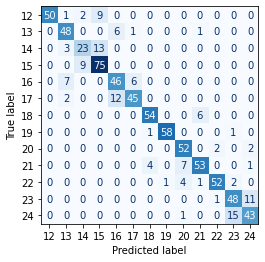

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y.tolist())))

disp.plot(cmap=plt.cm.Blues, colorbar = False)
plt.show()

Alternatively, we also tried using Deep Learning for our project, where we've attempted CNN-RNN (With pre-trained models), in hopes of capturing the spatial-temporal information for our IOP prediction tasks. So far, our deep learning results are unsatisfactory which may arise to the fact that our dataset may not be large enough for our problem. We are still in the midst of more data collection, where we will try deep learning again after collecting a larger dataset. Here is the 3D CNN code implementation we've tried for the project. Note that a different data processing is needed to prepare the data for deep elarning training which is not shown over here:

In [ ]:
def _3d_cnn_model(input_shape, num_classes):
    
    inputs = Input(shape=input_shape, name="input-layer")

    # Conv 1
    X = Conv3D(filters=16, kernel_size=(3, 1, 5), strides=(1, 1, 1), name="conv1-1")(inputs)
    X = PReLU(name="activation1-1")(X)
    X = Conv3D(filters=16, kernel_size=(3, 9, 1), strides=(1, 2, 1), name="conv1-2")(X)
    X = PReLU(name="activation1-2")(X)
    X = MaxPool3D(pool_size=(1, 1, 2), strides=(1, 1, 2), padding="valid", name="pool-1")(X)
    # X = Dropout(0.2)(X)

    # Conv 2
    X = Conv3D(filters=32, kernel_size=(3, 1, 4), strides=(1, 1, 1), name="conv2-1")(X)
    X = PReLU(name="activation2-1")(X)
    X = Conv3D(filters=32, kernel_size=(3, 8, 1), strides=(1, 2, 1), name="conv2-2")(X)
    X = PReLU(name="activation2-2")(X)
    X = MaxPool3D(pool_size=(1, 1, 2), strides=(1, 1, 2), padding="valid", name="pool-2")(X)
    # X = Dropout(0.2)(X)

    # Conv 3
    X = Conv3D(filters=64, kernel_size=(3, 1, 3), strides=(1, 1, 1), name="conv3-1")(X)
    X = PReLU(name="activation3-1")(X)
    X = Conv3D(filters=64, kernel_size=(3, 7, 1), strides=(1, 1, 1), name="conv3-2")(X)
    X = PReLU(name="activation3-2")(X)
    # X = Dropout(0.2)(X)

    # Conv 4
    X = Conv3D(filters=128, kernel_size=(3, 1, 3), strides=(1, 1, 1), name="conv4-1")(X)
    X = PReLU(name="activation4-1")(X)
    X = Conv3D(filters=128, kernel_size=(3, 7, 1), strides=(1, 1, 1), name="conv4-2")(X)
    X = PReLU(name="activation4-2")(X)
    # X = Dropout(0.2)(X)

    # Flatten
    X = Flatten()(X)

    # FC
    X = Dense(units=128, name="fc", activation='relu')(X)

    # Final Activation
    X = Dense(units=num_classes, activation='softmax', name="ac_softmax")(X)
    model = Model(inputs=inputs, outputs=X)

    return model


In [ ]:
# For the 3D CNN dataset we tried, we only used 10 IOP labels ( 15 - 24 mm Hg)
num_classes = 10

# Time steps we used for deep learning is 20 , where we first standardise across the dataset to have the same number of time steps which is 20 in this case
# The 80x40 size is expanded from the 8x5 sensor array to match the neural network shape requirements
input_shape = (20, 80, 40, 1)
epochs = 5

# Optimisers and loss technique used for deep learning 
opt = Adam()
loss = SparseCategoricalCrossentropy()


In [ ]:
# Initialise model
speech_cnn = _3d_cnn_model(input_shape, num_classes)

In [ ]:
# Compiling model
speech_cnn.compile(loss=loss,
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
# Reshape dataset to match neural network requirement 
X_dataset_train = np.reshape(X_dataset_train, (12, 20, 80, 40, 1))
X_dataset_test = np.reshape(X_dataset_test, (12, 20, 80, 40, 1))

In [ ]:
# Model Training 
speech_cnn.fit(X_dataset_train, Y_dataset_train,
                        epochs=epochs,
                        callbacks=None,
                        )

In [ ]:
# Assessing performance
_, acc = speech_cnn.evaluate(X_dataset_test, Y_dataset_test)
print(f"Test Accuracy: {acc*100}%")